# Importance sampling — infinite variance example

We seek to estimate the value function under the policy $\pi(\text{left}|s) = 1$ when the simulations are being sampled according to $\pi(\text{left} | s) = 1/2$.

The estimate of the value function $v_\pi(s)$ under ordinary importance sampling is given by

$$
     V(s) = \frac{\sum_{t\in{\mathfrak T}(s)} \rho_{t:T(t) -1}G_t}{| \mathfrak{T}(s) |}
$$
with
* $\mathfrak{T}(s)$  — the set of all time steps in which state $s$ is visited,
* $T(t)$ — the first time of termination following $t$, and
* $G_t = R_{t+1} + \gamma R_{t+2} + \ldots$ — the return after $t$ up though $T(t)$.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
# transition_matrix[left/right, state/end_state]
transition_matrix = np.array([
    [0.9, 0.1],
    [0.0, 1.0]
])


reward_matrix = np.array([
    [0.0,     1.0],
    [-np.inf, 0.0]
])

In [4]:
@njit
def set_seed(seed):
    np.random.seed(seed)
    

@njit
def step(state, policy):
    pr_actions = policy[state]
    action = np.random.multinomial(1, pvals=pr_actions).argmax()
    
    next_state = np.random.multinomial(1, pvals=transition_matrix[action]).argmax()
    ret = reward_matrix[action, next_state]
    
    return action, next_state, ret


@njit
def episode(state, policy):
    states, actions, returns = [state], [], []
    while state != 1:
        action, state, ret = step(state, policy)
        states.append(state)
        actions.append(action)
        returns.append(ret)
    
    states = np.array(states)
    actions = np.array(actions)
    returns = np.array(returns)
    return states, actions, returns


@njit(parallel=True)
def value_function_is(n_sims, policy_behaviour, policy_target):    
    state_init = 0
    rewards_all = np.zeros(n_sims)
    rho_all = np.zeros(n_sims)
    for n in prange(n_sims):
        states, actions, returns = episode(state_init, policy_behaviour)

        rewards = returns.sum()
        states_pre = states[:-1]

        rho_vals = (
            policy_target[:, actions].take(states_pre) / 
            policy_behaviour[:, actions].take(states_pre)
        ).prod()
        
        rewards_all[n] = rewards
        rho_all[n] = rho_vals
    
    return rewards_all, rho_all


@njit(parallel=True)
def value_function_is_runs(n_steps, n_runs, policy_behaviour, policy_target, seed=314):
    sims = np.zeros((n_steps, n_runs))
    for n in prange(n_runs):
        set_seed(seed + n)
        rewards, rho = value_function_is(n_steps, policy_behaviour, policy_target)
        mult_term = rewards * rho
        sims[:, n] = mult_term
    return sims

In [5]:
policy_behaviour = np.zeros((
    1, # non-terminal state
    2, # left or right
))

policy_behaviour[0, 0] = 1/2
policy_behaviour[0, 1] = 1/2

In [6]:
policy_target = np.zeros_like(policy_behaviour)
policy_target[0, 0] = 1.0

## Multiple simulations

In [7]:
%%time
seed = 314
n_sims = 10
n_steps = 10_000_000
sims = value_function_is_runs(n_steps, n_sims, policy_behaviour, policy_target, seed=seed)
sims = pd.DataFrame(sims)

CPU times: user 6min 30s, sys: 11.9 s, total: 6min 42s
Wall time: 11.1 s


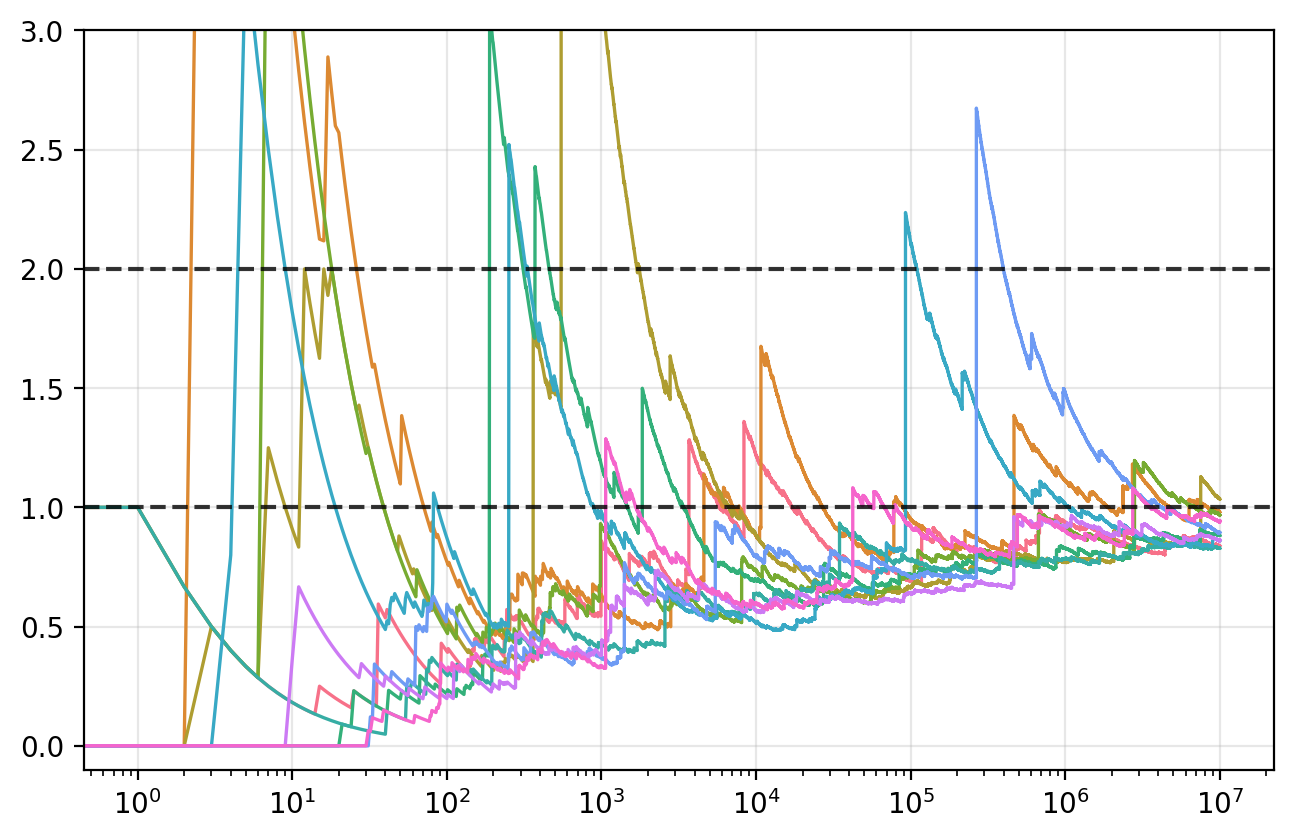

In [8]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8))
colors = sns.color_palette("husl", n_sims)
for n in range(n_sims):
    sims[n].expanding().mean().plot(color=colors[n], linewidth=1.2)
plt.grid(alpha=0.3)
plt.ylim(bottom=-0.1, top=3.0)
plt.axhline(y=1, c="black", linestyle="--", alpha=0.8)
plt.axhline(y=2, c="black", linestyle="--", alpha=0.8)
plt.xscale("log")

## Probability of return 1 under behaviour policy

In [9]:
# Emprical
((1 / 2 * 0.9) ** np.arange(100) * 1 / 2 * 0.1).sum()

0.09090909090909093

In [10]:
# limit
x = 1 / 2 * 0.9
1 / (1 - x) * 1 / 2 * 0.1

0.09090909090909091